In [1]:
source("tools.R")

Warning message:
"package 'plyr' was built under R version 3.3.3"Warning message:
"package 'tidyverse' was built under R version 3.3.3"Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Warning message:
"package 'ggplot2' was built under R version 3.3.3"Warning message:
"package 'tibble' was built under R version 3.3.3"Warning message:
"package 'tidyr' was built under R version 3.3.3"Warning message:
"package 'readr' was built under R version 3.3.3"Warning message:
"package 'purrr' was built under R version 3.3.3"Warning message:
"package 'dplyr' was built under R version 3.3.3"Conflicts with tidy packages ---------------------------------------------------
arrange():   dplyr, plyr
compact():   purrr, plyr
count():     dplyr, plyr
failwith():  dplyr, plyr
filter():    dplyr, stats
id():        dplyr, plyr
lag():       dplyr, stats
mutate():    dplyr, plyr
rename():    dplyr, plyr
summa

In [2]:
library(gridExtra)
library(lsr)

Warning message:
"package 'gridExtra' was built under R version 3.3.3"
Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine

Warning message:
"package 'lsr' was built under R version 3.3.2"

##### Bootstrapped confidence interval (for binomial distribution).

NOTE: Do you like this method Eric? Or should we use a package [like this one](http://math.furman.edu/~dcs/courses/math47/R/library/Hmisc/html/binconf.html)?

In [3]:
bp = function(x, lev, n = 1e4, alpha=0.05) {
  res = replicate(n, sum(sample(x, length(x), replace=TRUE) == lev)/length(x))
  return(list(mean=mean(res),
              `95% CI`=quantile(res, c(0.5*alpha,1-0.5*alpha))))
}

bp2 = function(vector, n = 1e4, alpha=0.05, round_n=2) {
    
    match_ci <- bp(x=vector, lev=TRUE, n=n, alpha=alpha)
    
    return( c( match_ci$mean %>% round(round_n),
             match_ci$`95% CI`[1] %>% round(round_n),
             match_ci$`95% CI`[2] %>% round(round_n) ))
}

In [4]:
standardize_range_one <- function(array) {
    (array - min(array)) / (max(array) - min(array))
}

In [188]:
# Kernel composition name change
#l+r+p -> l+p+r
#l+r*p -> l+p*r
#l*r*p -> l*p*r

readable_kernel <- function(current_kernel){
    new_kernel <- current_kernel
    
    new_kernel <- ifelse(new_kernel == 'l+r+p', 'l+p+r', new_kernel)
    new_kernel <- ifelse(new_kernel == 'l+r*p', 'l+p*r', new_kernel)
    new_kernel <- ifelse(new_kernel == 'l*r*p', 'l*p*r', new_kernel)
    
    new_kernel <- gsub("\\*", "×", new_kernel)
    
    return(new_kernel)
}

# Get the range of a scenario
get_range <- function(scenario_name) {
    switch( scenario_name,
            'Temperature' = c(-10, 40),
            'Rain' = c(0, 100),
            'Sales' = c(0, 5000),
            'Gym members' = c(0, 50),
            'Salary' = c(0, 50),
            'FB Friends' = c(0, 1000))
}

kernels    <- c("l", "p", "r", "l+p", "l+r", "p+r", "l*r", "l*p", "p*r", "l+r+p", "l+r*p", "l*r+p", "l*p+r", "l*r*p")

kernels_2  <- c("l", "p", "r", "l+p", "l+r", "p+r", "l×r", "l×p", "p×r", "l+p+r", "l+p×r", "l×r+p", "l×p+r", "l×p×r")

# Plotting functions

In [6]:
plot_lmls <- function(prop_data, title='', scenario, hide_x=FALSE, hide_y=FALSE, red_border=TRUE) {
    
    # Best-fitting real-world data kernel composition
    rw_lmls <- read_csv("data/real-world/to-plot.csv")
    red_kernel <- (rw_lmls %>%
                    filter(kernel != 'l', kernel != 'p', kernel != 'r') %>%
                    filter(scenario == !!scenario) %>%
                    summarize(red_kernel = kernel[which.max(lml)]))$red_kernel
    red_kernel <- readable_kernel(red_kernel)

    plot <- prop_data %>%
                ggplot(aes(x=kernel, y=value)) +
                    geom_bar(stat='identity') +
                    geom_bar(stat='identity', data=prop_data %>% filter(kernel == red_kernel), alpha=0, size=0.5, color="red") +
                    coord_cartesian (ylim=c(0, 1)) +
                    #labs(title = title) +
                    ggthemes::theme_few() +
                    xlab("Kernel composition") +
                    ylab("Likelihood") +
                    geom_errorbar(aes(ymin=as.numeric(lo_ci), ymax=as.numeric(hi_ci)),
                                      width=.3,
                                      position=position_dodge(.9)) +
                    scale_y_continuous(breaks = seq(0, 1, length.out=3)) +
                    theme(axis.text.x = element_text(angle = 90,  vjust = 0.5, hjust=0),
                          text = element_text(size=12, family="serif"))

    if(hide_x){
        plot <- plot + theme(axis.title.x=element_blank())
    }
    if(hide_y){
        plot <- plot + theme(axis.title.y=element_blank())
    }
    
    return(plot)
}

In [7]:
plot_curves <- function(plot_data, plot_rwdata, ylab='', scenario, hide_x=FALSE, hide_y=FALSE) {

    # Min and max value of the data to be shown
    range_y <- get_range(scenario)
    limits_y <- c( min(range_y[1], min(plot_data$value)), max(range_y[2], max(plot_data$value)))
    
    # Mean trend
    trend <- plot_data %>% group_by(day) %>% summarize(mean_y = mean(value))
    
    # Resolution subsetting
    resolution = 10 #smaller number is higher resolution
    plot_data <- plot_data %>% filter((day - min(day)) %% resolution == 0)
    trend <- trend %>% filter((day - min(day)) %% resolution == 0)
    
    # Plotting
    plot <- plot_data %>%
                ggplot(aes(x=day, y=value, group=id)) +
                    geom_line(col="steelblue", alpha=0.2) + # Participants' curves
                    geom_line(data=plot_rwdata, aes(x=day, group=1), colour="red", alpha=0.6) + # Real world data
                    geom_line(data=trend, aes(x=day, y=mean_y, group=1), colour="black") + # Mean trend
                    #labs(title = title) +
                    ggthemes::theme_few() +
                    ylab(ylab) +
                    scale_x_continuous(breaks = c(0, 365, 365*2, 365*3), labels=c('Y1', 'Y2', 'Y3', 'Y4')) +
                    scale_y_continuous(breaks = seq(range_y[1], range_y[2], length.out=3), limits=limits_y) +
                    theme(axis.text.x = element_text(angle = 90,  vjust = 0.5, hjust=0),
                          axis.text.y = element_text(angle = 90,  vjust = 0.5, hjust=0.5),
                          text = element_text(size=12, family="serif"))

    if(hide_x){
        plot <- plot + theme(axis.title.x=element_blank())
    }
    if(hide_y){
        plot <- plot + theme(axis.title.y=element_blank())
    }
    
    return(plot)
}

# Prior: Kernel compositions bar plots

##### Import and prepare the data

In [8]:
data_prior <- read_csv("data/for_composititional_analysis_prior.csv")

# Get a "dictionary" of ID, PID, Scenario
dict_prior <- data_prior %>%                        
                        group_by(id, pid, scenario) %>%
                        summarize()

# Get the results of the LML analysis over the prior data
prior_results <- read_csv('output/minus-mean-treatment/results_prior_lmls.csv')

# Merge the results with the dictionary to have a 'full view' of the situation
lmls_prior <- merge(prior_results, dict_prior, by.x='cid', by.y='id', all.x=TRUE)

# Kernel composition name change
lmls_prior$kernel <- readable_kernel(lmls_prior$kernel)

Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  X1 = col_integer(),
  id = col_integer(),
  pid = col_character(),
  scenario = col_character(),
  x = col_integer(),
  y = col_double()
)
Parsed with column specification:
cols(
  cid = col_integer(),
  kernel = col_character(),
  lml = col_double(),
  white_added = col_character(),
  second_exception = col_character()
)


In [9]:
# Removes the GPs that failed to be optimized in the second time. The lmls that failed to be optimized are also removed.
#Finaly, the lml_standard is calculated
lmls_prior_f <- lmls_prior %>%
                    filter(kernel != 'l', kernel != 'p', kernel != 'r') %>%
                    filter(second_exception == 'False' & lml != -999999999)

sds <- lmls_prior_f %>% 
            group_by(kernel, scenario) %>%
            summarize(lo_bound = mean(lml) - 5*sd(lml), up_bound = mean(lml) + 5*sd(lml))

sds$ks <- paste0(sds$kernel, sds$scenario)

lmls_prior_f$ks <- paste0(lmls_prior_f$kernel, lmls_prior_f$scenario)

sds$kernel <- NULL
sds$scenario <- NULL

lmls_prior_f <- merge(x = lmls_prior_f, y = sds, by = "ks", all.x = TRUE)

##### Prepare the plots

In [10]:
plot_bool      = TRUE

lmls_prior_ff <- lmls_prior_f %>%
            filter(lml > lo_bound & lml < up_bound)

# Remove single components AND for each participant-scenario combination, make a 0 to 1 range
to_plot_prior <- lmls_prior_ff %>%
                    group_by( pid, scenario ) %>%
                    mutate( lml = standardize_range_one(lml) )

# Produce means and confidence intervals
to_plot_prior <- to_plot_prior %>%
            group_by(kernel, scenario) %>%
            summarize(value = mean(lml),
                      lo_ci = MeanCI(lml, method="boot", type="norm", na.rm=TRUE)['lwr.ci'],
                      hi_ci = MeanCI(lml, method="boot", type="norm", na.rm=TRUE)['upr.ci'])

# Plotting magic
to_plot_prior$kernel <- factor(to_plot_prior$kernel, levels=readable_kernel(kernels))


if (plot_bool) {
    # Plots
    p_temp   <- plot_lmls( to_plot_prior %>% filter(scenario == "Temperature"), scenario="Temperature", hide_x=TRUE, hide_y=FALSE)
    p_rain   <- plot_lmls( to_plot_prior %>% filter(scenario == "Rain"),        scenario="Rain",        hide_x=TRUE, hide_y=FALSE)
    p_sales  <- plot_lmls( to_plot_prior %>% filter(scenario == "Sales"),       scenario="Sales",       hide_x=TRUE, hide_y=FALSE)
    p_gym    <- plot_lmls( to_plot_prior %>% filter(scenario == "Gym members"), scenario="Gym members", hide_x=TRUE, hide_y=FALSE)
    p_salary <- plot_lmls( to_plot_prior %>% filter(scenario == "Salary"),      scenario="Salary",      hide_x=TRUE, hide_y=FALSE)
    p_fb     <- plot_lmls( to_plot_prior %>% filter(scenario == "FB Friends"),  scenario="FB Friends",  hide_x=TRUE, hide_y=FALSE)

    #pdf("Images/paper_images/kernels_priors_lmls_5sd.pdf", width=8, height=4)
    #multiplot(p1, p2, p3, p4, p5, p6, cols=3)
    #dev.off()   
}

Parsed with column specification:
cols(
  scenario = col_character(),
  kernel = col_character(),
  lml = col_double()
)
Parsed with column specification:
cols(
  scenario = col_character(),
  kernel = col_character(),
  lml = col_double()
)
Parsed with column specification:
cols(
  scenario = col_character(),
  kernel = col_character(),
  lml = col_double()
)
Parsed with column specification:
cols(
  scenario = col_character(),
  kernel = col_character(),
  lml = col_double()
)
Parsed with column specification:
cols(
  scenario = col_character(),
  kernel = col_character(),
  lml = col_double()
)
Parsed with column specification:
cols(
  scenario = col_character(),
  kernel = col_character(),
  lml = col_double()
)


## Tests for Prior condition

#### Best fitting kernel compositions

In [11]:
to_plot_prior %>%
    group_by(scenario) %>%
    summarize(composition = kernel[which.max(value)], value = value[which.max(value)]) %>%
    arrange(scenarios_order(scenario))

# Which other kernel compositions are statistically equivalent
to_plot_prior %>%
    group_by(scenario) %>%
    filter(hi_ci > lo_ci[which.max(value)]) %>%
    select(scenario, composition = kernel, value, lo_ci, hi_ci) %>%
    arrange(scenarios_order(scenario), -value)

scenario,composition,value
Temperature,p×r,0.9192010
Rain,p×r,0.9185013
Sales,l+r,0.9652802
Gym members,p×r,0.8959303
Salary,l+r,0.8576757
FB Friends,l+r,0.9315774


scenario,composition,value,lo_ci,hi_ci
Temperature,p×r,0.9192010,0.8801756,0.9575137
Rain,p×r,0.9185013,0.8819013,0.9543502
Rain,l+r,0.8727970,0.8468486,0.8995264
Rain,l+p×r,0.8647992,0.8251855,0.9047734
Sales,l+r,0.9652802,0.9498349,0.9801867
Gym members,p×r,0.8959303,0.8574413,0.9348408
Salary,l+r,0.8576757,0.8165901,0.8967853
Salary,p+r,0.8078211,0.7526040,0.8627519
FB Friends,l+r,0.9315774,0.9160463,0.9476402
FB Friends,l+p×r,0.8974742,0.8688241,0.9273888


#### Percentage of removed GPs in the Prior condition:

In [12]:
# Percentage of removed GPs in the Prior condition:
((1 -
lmls_prior_ff %>%
    filter(kernel != 'l', kernel != 'p', kernel != 'r') %>%
    nrow / 
lmls_prior %>%
    filter(kernel != 'l', kernel != 'p', kernel != 'r') %>%
    nrow) * 100) %>%
round(2)


[1] 5.02

#### Ranking correlation: participants -> real-world

In [13]:
# Get the real world data and make it readable
to_merge_rw_lmls <- read_csv("data/real-world/to-plot.csv")
to_merge_rw_lmls$kernel <- readable_kernel(to_merge_rw_lmls$kernel)

# Filter out the non-compositional kernels
to_merge_rw_lmls <- to_merge_rw_lmls %>% 
                filter(kernel != 'l', kernel != 'p', kernel != 'r')

# Raw prior data: lmls_prior 
to_merge_lmls_prior <- lmls_prior_ff %>% filter(kernel != 'l', kernel != 'p', kernel != 'r')

# Merging the real world data with the prior results
lmls_prior_new <- merge(x = to_merge_lmls_prior, 
                        y = to_merge_rw_lmls,
                        by = c('scenario', 'kernel'),
                        suffixes = c("_participants","_real_world")
                        )

Parsed with column specification:
cols(
  scenario = col_character(),
  kernel = col_character(),
  lml = col_double()
)


In [209]:
# Calculate the rank correlation
print('Per scenario')

dcor1 <- ddply(lmls_prior_new, ~scenario+pid, summarize, r=cor(rank(lml_participants), rank(lml_real_world)))

dout <- ddply(dcor1, ~scenario, summarize, m=cohensD(r))
test_results_per_scenario <- tapply(dcor1$r, dcor1$scenario, t.test)


print('Overall')

dcor2 <- ddply(lmls_prior_new, ~pid, summarize, r=cor(rank(lml_participants), rank(lml_real_world)))

t.test(dcor2$r)
cohensD(dcor2$r) %>% round(2)

[1] "Per scenario"
[1] "Overall"



	One Sample t-test

data:  dcor2$r
t = 13.912, df = 118, p-value < 2.2e-16
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 0.1184958 0.1578284
sample estimates:
mean of x 
0.1381621 


[1] 1.28

In [210]:
print_test_results <- function(scenario_name, readable_s_name){
    df <- test_results_per_scenario[[scenario_name]][[2]]
    p_val <- ifelse(test_results_per_scenario[[scenario_name]][[3]] < 0.001, 
                "<0.001", 
                test_results_per_scenario[[scenario_name]][[3]])
    t <- test_results_per_scenario[[scenario_name]][[1]] %>% round(2)

    d_val <- (dout %>% filter(scenario == scenario_name))$m %>% round(2)

    rho <- test_results_per_scenario[[scenario_name]][[5]] %>% round(2)
    
    t_string <- paste0(", $\rho=", rho,"$", " ($t(", df, ")=", t, ", p", p_val, ", d=", d_val, "$)")
    
    paste0(t_string, " for the ", readable_s_name, " data")
}

In [211]:
paste0(  print_test_results('Temperature', 'Temperature'),
        print_test_results('Rain', 'Rain'),
        print_test_results('Sales', 'Sales'),
        print_test_results('Gym members', 'Gym members'),
        print_test_results('Salary', 'Salary'),
        print_test_results('FB Friends', 'Facebook friends')) %>% print

[1] ", $\rho=0.61$ ($t(118)=32.26, p<0.001, d=2.96$) for the Temperature data, $\rho=0.58$ ($t(118)=24.63, p<0.001, d=2.26$) for the Rain data, $\rho=0.48$ ($t(118)=20.23, p<0.001, d=1.85$) for the Sales data, $\rho=0.16$ ($t(118)=6.41, p<0.001, d=0.59$) for the Gym members data, $\rho=0.61$ ($t(118)=37.3, p<0.001, d=3.42$) for the Salary data, $\rho=0.62$ ($t(118)=33.62, p<0.001, d=3.08$) for the Facebook friends data"


#### Cross-validation per scenario

In [346]:
# Initial variables
cross_lmls_prior <- lmls_prior_new
cross_scenarios <- sort(readable_scenarios) 
cross_scenarios_init <- sort(readable_scenarios) 

results <- data.frame(col1 = character(), col2 = character(), col3 = double())
colnames(results) <- c('real_world_scenario', 'explained_by_participants_scenario', 'rho')

#### Begin cycle ####
y = 0
while(y < 6){
    
    y = y + 1

    # For the later validation
    cross_lmls_prior_initial <- cross_lmls_prior 

    # Grouping and sorting
    real_world_lmls <- cross_lmls_prior %>%
                        select(scenario, kernel, lml_real_world) %>%
                        unique %>%
                        arrange(scenario, kernel)

    # Round robin
    new_lmls_round_robin <- c( real_world_lmls$lml_real_world[12:66], 
                               real_world_lmls$lml_real_world[1:11] )

    # Round robin in the name of the scenarios (to interpret the results)
    cross_scenarios <- c(cross_scenarios[2:6], cross_scenarios[1])

    # Replacing the LMLs column with the round robin one
    real_world_lmls$lml_real_world <- new_lmls_round_robin

    # Eliminate column from dataframe
    cross_lmls_prior$lml_real_world <- NULL

    # Place this into initial dataframe
    cross_lmls_prior <- merge( x = cross_lmls_prior,
                               y = real_world_lmls, 
                               by = c('scenario', 'kernel'))

    # Validation
    print('All should be TRUE:')
    # TODO: Print
    print(((cross_lmls_prior %>% select(scenario, kernel, lml_real_world) %>% unique %>% arrange(scenario, kernel) %>% tail(11) %>% 
        select(lml_real_world)) == (cross_lmls_prior_initial  %>% select(scenario, kernel, lml_real_world) %>% unique %>% arrange(scenario, kernel) %>% head(11) %>% select(lml_real_world))) )

    # Correlation calculations
    cross_dcor1 <- ddply(cross_lmls_prior, ~scenario+pid, summarize, r=cor(rank(lml_participants), rank(lml_real_world)))
    cross_dout <- ddply(cross_dcor1, ~scenario, summarize, m=cohensD(r))
    cross_test_results_per_scenario <- tapply(cross_dcor1$r, cross_dcor1$scenario, t.test)

    get_rho <- function(index){
        c( cross_scenarios[index],
           cross_scenarios_init[index],
           (cross_test_results_per_scenario[[cross_scenarios_init[index]]][[5]] %>% round(2))[[1]] )
    }

    # Calculate the Rhos
    rho_1 <- get_rho(1)
    rho_2 <- get_rho(2)
    rho_3 <- get_rho(3)
    rho_4 <- get_rho(4)
    rho_5 <- get_rho(5)
    rho_6 <- get_rho(6)

    # Bind them to the dataframe
    partial_results <- t(data.frame(rho_1, rho_2, rho_3, rho_4, rho_5, rho_6))
    colnames(partial_results) <- c('real_world_scenario', 'explained_by_participants_scenario', 'rho')
    
    results <- rbind(results, partial_results)
}

[1] "All should be TRUE:"
   lml_real_world
56           TRUE
57           TRUE
58           TRUE
59           TRUE
60           TRUE
61           TRUE
62           TRUE
63           TRUE
64           TRUE
65           TRUE
66           TRUE
[1] "All should be TRUE:"
   lml_real_world
56           TRUE
57           TRUE
58           TRUE
59           TRUE
60           TRUE
61           TRUE
62           TRUE
63           TRUE
64           TRUE
65           TRUE
66           TRUE
[1] "All should be TRUE:"
   lml_real_world
56           TRUE
57           TRUE
58           TRUE
59           TRUE
60           TRUE
61           TRUE
62           TRUE
63           TRUE
64           TRUE
65           TRUE
66           TRUE
[1] "All should be TRUE:"
   lml_real_world
56           TRUE
57           TRUE
58           TRUE
59           TRUE
60           TRUE
61           TRUE
62           TRUE
63           TRUE
64           TRUE
65           TRUE
66           TRUE
[1] "All should be TRUE:"
   lml

In [352]:
# Transform value
results_converted <- results
results_converted$rho <- as.numeric(levels(results$rho))[results$rho]

# Rho squared
results_converted$rho_squared <- results_converted$rho * results_converted$rho

In [369]:
cross_validation_rhos <- results_converted %>%
                        filter(real_world_scenario != explained_by_participants_scenario) %>%
                        group_by(real_world_scenario) %>%
                        summarize(rho_squared_mean = mean(rho_squared))

original_rhos <- results_converted %>%
                        filter(real_world_scenario == explained_by_participants_scenario)

final_results <- (merge( x = original_rhos,
                        y = cross_validation_rhos,
                        by = c('real_world_scenario'))) %>%
                  mutate(difference = (rho_squared - rho_squared_mean) %>% round(2))

In [370]:
final_results

real_world_scenario,explained_by_participants_scenario,rho,rho_squared,rho_squared_mean,difference
FB Friends,FB Friends,0.62,0.3844,0.37206,0.01
Gym members,Gym members,0.16,0.0256,0.06252,-0.04
Rain,Rain,0.58,0.3364,0.18094,0.16
Salary,Salary,0.61,0.3721,0.21670,0.16
Sales,Sales,0.48,0.2304,0.33004,-0.10
Temperature,Temperature,0.61,0.3721,0.28840,0.08


In [377]:
print(paste0( "positive in the temperature ($", final_results[final_results$real_world_scenario=='Temperature', 'difference'], 
                            "$), rain ($", final_results[final_results$real_world_scenario=='Rain', 'difference'],
                          "$), salary ($", final_results[final_results$real_world_scenario=='Salary', 'difference'], 
            "$), and Facebook friends ($", final_results[final_results$real_world_scenario=='FB Friends', 'difference'],  
       "$) scenarios."))

[1] "positive in the temperature ($0.08$), rain ($0.16$), salary ($0.16$), and Facebook friends ($0.01$) scenarios."


# Prior: Curves (participant's data)

##### Plotting

In [17]:
mean_centering <- function(rwdata, dat, scenario) {
    mean_rw <- rwdata %>% filter(scenario == !!scenario) %>% summarize(mv=mean(value))
    
    mean_dat <- dat %>% filter(scenario == !!scenario, condition == 'Prior') %>% summarize(mv=mean(value))    
    
    mean_dat$mv / mean_rw$mv
}

# Real world data
rwdata <- read_csv('data/real-world/splines.csv')

rwdata$condition <- 'Prior' # Add column
rwdata$id <- 1 #Create a new ID column
rwdata <- filter(rwdata, day >= 31) # Filter out the initial days
rwdata <- filter(rwdata, day <= 365*4 - 31) # Filter out the final days

# Order
rwdata$condition <- factor( rwdata$condition, levels = condition_names)
rwdata$scenario <- factor( rwdata$scenario, levels = readable_scenarios)

# Scale the values
#rwdata[rwdata$scenario == 'Rain', 'day'] <- rwdata[rwdata$scenario == 'Rain', 'day'] + (365/12) * 1.5 #Offset 1.5 months to the right

# Mean centering
for (s in readable_scenarios){
    rwdata[rwdata$scenario == s, 'value'] <- rwdata[rwdata$scenario == s, 'value'] * mean_centering(rwdata, dat, s)
}

Parsed with column specification:
cols(
  scenario = col_character(),
  day = col_integer(),
  value = col_double()
)


In [18]:
curves_plot <- function(scenario_name, ...) {
    dat %>% 
        filter(scenario==scenario_name, condition=='Prior') %>% 
        plot_curves(rwdata %>% filter(scenario==scenario_name), scenario=scenario_name, ylab=scenario_name, ...)
}

In [19]:
p_temp_curves   <- curves_plot('Temperature', hide_x=TRUE, hide_y=FALSE)
p_rain_curves   <- curves_plot('Rain',        hide_x=TRUE, hide_y=FALSE)
p_sales_curves  <- curves_plot('Sales',       hide_x=TRUE, hide_y=FALSE)
p_gym_curves    <- curves_plot('Gym members', hide_x=TRUE, hide_y=FALSE)
p_salary_curves <- curves_plot('Salary',      hide_x=TRUE, hide_y=FALSE)
p_fb_curves     <- curves_plot('FB Friends',  hide_x=TRUE, hide_y=FALSE)

In [20]:
if(FALSE){
    # Save/show
    pdf("Images/paper_images/grid_plot_prior_new.pdf", width=6, height=10)
    grid.arrange(p_temp_curves,   p_temp, 
                 p_rain_curves,   p_rain, 
                 p_sales_curves,  p_sales, 
                 p_gym_curves,    p_gym, 
                 p_salary_curves, p_salary, 
                 p_fb_curves,     p_fb, 
                 ncol=2)
    dev.off()   
}

# Posterior: Curves (participants' data)

In [21]:
plot_curves_posterior <- function(plot_data, ylab='', scenario, hide_x=FALSE, hide_y=FALSE) {

    # Min and max value of the data to be shown
    range_y <- get_range(scenario)
    limits_y <- c( min(range_y[1], min(plot_data$value)), max(range_y[2], max(plot_data$value)))
    
    # Mean trend
    trend_1 <- plot_data %>% filter(condition=='Posterior-Positive') %>% group_by(day) %>% summarize(mean_y = mean(value))
    trend_2 <- plot_data %>% filter(condition=='Posterior-Stable') %>%   group_by(day) %>% summarize(mean_y = mean(value))
    trend_3 <- plot_data %>% filter(condition=='Posterior-Negative') %>% group_by(day) %>% summarize(mean_y = mean(value))
    
    # Resolution subsetting
    resolution = 10 #smaller number is higher resolution
    plot_data <- plot_data %>% filter((day - min(day)) %% resolution == 0)
    trend_1 <- trend_1 %>% filter((day - min(day)) %% resolution == 0)
    trend_2 <- trend_2 %>% filter((day - min(day)) %% resolution == 0)
    trend_3 <- trend_3 %>% filter((day - min(day)) %% resolution == 0)
    
    # Plotting
    plot <- plot_data %>%
                ggplot(aes(x=day, y=value, group=id)) +
                    # Curves:
                    geom_line(data=plot_data %>% filter(condition=='Posterior-Positive'), col="steelblue", alpha=0.1) +
                    geom_line(data=plot_data %>% filter(condition=='Posterior-Stable'),   col="olivedrab", alpha=0.1) +
                    geom_line(data=plot_data %>% filter(condition=='Posterior-Negative'), col="firebrick", alpha=0.1) +
                    
                    # Mean curves
                    geom_line(data=trend_1, aes(x=day, y=mean_y, group=1), colour="blue") +
                    geom_line(data=trend_2, aes(x=day, y=mean_y, group=1), colour="darkgreen") +
                    geom_line(data=trend_3, aes(x=day, y=mean_y, group=1), colour="red") +
                    
                    # Vertical line (end of evidence mark)
                    geom_vline(aes(xintercept=365-31), colour='black') +
    
                    ggthemes::theme_few() +
                    ylab(ylab) +
                    scale_x_continuous(breaks = c(0, 365, 365*2, 365*3), labels=c('Y1', 'Y2', 'Y3', 'Y4')) +
                    scale_y_continuous(breaks = seq(range_y[1], range_y[2], length.out=3), limits=limits_y) +
                    theme(axis.text.x = element_text(angle = 90,  vjust = 0.5, hjust=0),
                          axis.text.y = element_text(angle = 90,  vjust = 0.5, hjust=0.5),
                          text = element_text(size=12, family="serif"))

    if(hide_x){
        plot <- plot + theme(axis.title.x=element_blank())
    }
    if(hide_y){
        plot <- plot + theme(axis.title.y=element_blank())
    }
    
    return(plot)
}
    
curves_plot_posterior <- function(scenario_name, ...) {
    dat %>% 
        filter(scenario==scenario_name, condition!='Prior') %>% 
        plot_curves_posterior(scenario=scenario_name, ylab=scenario_name, ...)
}

In [22]:
posterior_curves_temp <- curves_plot_posterior('Temperature', hide_x=TRUE, hide_y=FALSE)
posterior_curves_rain <- curves_plot_posterior('Rain',        hide_x=TRUE, hide_y=FALSE)
posterior_curves_sale <- curves_plot_posterior('Sales',       hide_x=TRUE, hide_y=FALSE)
posterior_curves_gymm <- curves_plot_posterior('Gym members', hide_x=TRUE, hide_y=FALSE)
posterior_curves_slry <- curves_plot_posterior('Salary',      hide_x=TRUE, hide_y=FALSE)
posterior_curves_fbfr <- curves_plot_posterior('FB Friends',  hide_x=TRUE, hide_y=FALSE)

# Posterior: Performance. Prediction against participant's results

##### Importing the posterior kernel composition data

In [23]:
#Returns the data (after double filtering)
get_filtered_data <- function(src_lmls, src_dict) {
    lmls_posterior <- read_csv(src_lmls)

    
    # To add the 'scenario' column
    data_posterior <- read_csv(src_dict)


    # Posterior "dictionary"
    dict_posterior <- data_posterior %>%                        
                            group_by(id, pid, scenario, condition) %>%
                            summarize()

    lmls_posterior <- merge(x = lmls_posterior, y = dict_posterior, by = c("id", "id"), all.x = TRUE)

    # Removing unusable data
    lmls_posterior_f <- lmls_posterior %>%
                        filter(kernel != 'l', kernel != 'p', kernel != 'r') %>%
                        filter(second_exception == 'False' & lml != -999999999)

    # Standard deviations calculation
    sds <- lmls_posterior_f %>% 
                group_by(kernel, scenario) %>%
                summarize(lo_bound = mean(lml) - 5*sd(lml), up_bound = mean(lml) + 5*sd(lml))

    sds$ks <- paste0(sds$kernel, sds$scenario)

    lmls_posterior_f$ks <- paste0(lmls_posterior_f$kernel, lmls_posterior_f$scenario)

    sds$kernel <- NULL
    sds$scenario <- NULL

    lmls_posterior_f <- merge(x = lmls_posterior_f, y = sds, by = "ks", all.x = TRUE)

    lmls_posterior_ff <- lmls_posterior_f %>%
                filter(lml > lo_bound & lml < up_bound)
    
    return (lmls_posterior_ff)
}

In [24]:
lmls_posterior_ff <- get_filtered_data( "output/minus-mean-treatment/results_posterior_lmls.csv",
                                        "data/for_composititional_analysis_posterior.csv" )

Parsed with column specification:
cols(
  id = col_integer(),
  kernel = col_character(),
  lml = col_double(),
  white_added = col_character(),
  second_exception = col_character()
)
Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  X1 = col_integer(),
  id = col_integer(),
  pid = col_character(),
  scenario = col_character(),
  x = col_integer(),
  y = col_double(),
  condition = col_character()
)


###### Importing the predictions

In [25]:
# Import the predictions
predictions_csv <- read_csv('output/minus-mean-treatment/results_posterior_predictions.csv')

predictions <- predictions_csv %>%
                    mutate(value = as.numeric(substring(predictions_mean, 2, nchar(predictions_mean)-1))) %>%
                    select(cid = pid, kernel = composition, day = Xpredictions, value)

Parsed with column specification:
cols(
  pid = col_integer(),
  composition = col_character(),
  Xpredictions = col_double(),
  predictions_mean = col_character(),
  predictions_var = col_character()
)


In [26]:
# Add the subtracted mean of the 'evidence' data
posterior_means <- read_csv("data/for_composititional_analysis_posterior.csv") %>% #data_posterior
                        filter(x <= 365-31) %>%
                        group_by(id) %>%
                        summarize(mean_cid = mean(y))

predictions <- merge(x=predictions, y=posterior_means, by.x='cid', by.y='id', all.x=TRUE)

predictions <- predictions %>% 
                    mutate(value = value + mean_cid) %>%
                    select(-mean_cid)

Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  X1 = col_integer(),
  id = col_integer(),
  pid = col_character(),
  scenario = col_character(),
  x = col_integer(),
  y = col_double(),
  condition = col_character()
)


In [27]:
predictions %>% select(cid) %>% unique %>% nrow

predictions %>% select(cid, kernel) %>% unique %>% nrow

[1] 714

[1] 9996

##### Merging and filtering the datasets

In [28]:
# Sequence of days to analyze:
sequence = seq(365-31 + 2, 1426, 5)

In [29]:
# Inner join. 
# This is the predictions data merged with the best performing (and filtered) kernels in the posterior condition
pred <- merge( 
            # Predictions (full-Bayesian):
            x = predictions %>%
                    filter(day %in% sequence),

            # Kernels after the filters:
            y = lmls_posterior_ff %>%
                    select(cid=id, pid, scenario, kernel, lml),
            
            all.y = TRUE,
            by = c('cid', 'kernel')
)

# Participants' data
participants_data <- dat %>% 
                        filter(day > 365-31, #remove evidence
                               condition != 'Prior', #only Posterior conditions
                               day %in% sequence) %>%
                        select(pid = id, day, value_participant=value, scenario, condition, noise)

# Merge the predictions with the real participants' data
all_pred_data <- merge(
                # Predictions + Kernel posterior analysis:
                x = pred,
    
                # Participant's data:
                y = participants_data,
    
                by = c('pid', 'scenario', 'day')
)

In [30]:
all_pred_data %>% select(cid) %>% unique %>% nrow

all_pred_data %>% select(cid, kernel) %>% unique %>% nrow

[1] 714

[1] 7724

###### Calculating the deviation

In [31]:
#Normalized root mean squared deviation
calculate_nrmsd <- function(value_prediction, value_participant) {
    return (sqrt(sum((value_prediction - value_participant)^2) / length(value_prediction)) / (max(value_participant) - min(value_participant)))
}

#Normalized root mean squared error (as per Mozer et al. (2008))
calculate_nrmse <- function(value_model, value_human) {
    return ( sqrt( sum((value_human - value_model)^2) / sum((value_human - mean(value_human))^2) ) )
}

calculate_mean_error <- function(value_model, value_human) {
    return ( mean(abs(value_model - value_human)) )
}

In [32]:
results_pred <- all_pred_data %>% 
                    mutate(kernel = readable_kernel(kernel)) %>%
                    group_by(pid, scenario, kernel, lml) %>%
                    summarize(error = calculate_nrmse(value, value_participant))
                    #summarize(error = calculate_mean_error(value, value_participant))

# Third grid plot. 
Identical to the posterior grid plot, but the right column is a scatterplot of prior likelihood vs posterior performance

In [33]:
# Raw LML in the fitting of the GPs onto the prior stage data
scatterplot_data_prior <- lmls_prior_ff %>%
                            select(pid, scenario, kernel, lml)

# Raw Error in the posterior predictions
scatterplot_data_posterior <- results_pred %>%
                                select(pid, scenario, kernel, lml, error_posterior=error)

scatterplot_data <- merge(
                            x = scatterplot_data_prior,
                            y = scatterplot_data_posterior,
                            by = c('pid', 'scenario', 'kernel'),
                            suffixes = c('_prior', '_posterior') )

#### Charley Wu Magic

In [34]:
library(MASS)

plot_scenario_scatterplot_wu <- function(data_to_plot, scenario_name, y_max) {
    
    y_max = 11
    
    # Filter and normalize
    aux <- data_to_plot %>% 
            filter(kernel != 'l', kernel != 'p', kernel != 'r') %>%
            filter(scenario == scenario_name) %>%
            group_by( pid, scenario ) %>%
            mutate(lml_normalized = standardize_range_one(lml_prior),
                   error_normalized = standardize_range_one(error_posterior), 
                   error_ranking = rank(error_posterior))

    # Only analysis dataframe
    cor1D <- data.frame(lambda1 = aux$lml_normalized, 
                        lambda2 = aux$error_ranking)
    
    # Correlation test
    lambdaCor <- cor.test(cor1D$lambda1, cor1D$lambda2)

    # Bivariate point density
    cor1D$lambdadensity <- fields::interp.surface(MASS::kde2d(cor1D$lambda1, cor1D$lambda2), cor1D[,c("lambda1", "lambda2")])
    
    # Plot
    ggplot(cor1D, aes(lambda1, lambda2, fill=lambdadensity, alpha = standardize_range_one(1/lambdadensity))) +
        geom_point(pch=21, size = 2.0, color='white')+
        geom_smooth(method='lm', color='black', se=FALSE, linetype=2, fullrange=TRUE)+
        scale_fill_gradient(low = "#0091ff", high = "#f0650e") +
        scale_alpha(range = c(.4, 1)) + guides(alpha="none", fill="none") +
        #expand_limits(x = 0, y = 0) +
        #annotate("text", x = 1, y = 6, label = "r == 0.62 * ~~'p<.001'", parse=TRUE, size=6) +
    
        coord_cartesian(ylim = c(0, y_max))  +
        scale_x_continuous(breaks = seq(0, 1, length.out=3)) +
        scale_y_continuous(breaks = seq(1, y_max, length.out=2)) +
        
        xlab('Likelihood in Prior') + 
        ylab('Error in Posterior') +
    
        ggthemes::theme_few() +
        theme(text = element_text(size=10, family="serif"),
                     legend.position = "none")
}

scatter_temp_wu <- plot_scenario_scatterplot_wu(scatterplot_data, 'Temperature', y_max = 30)
scatter_rain_wu <- plot_scenario_scatterplot_wu(scatterplot_data, 'Rain',        y_max = 30)
scatter_sale_wu <- plot_scenario_scatterplot_wu(scatterplot_data, 'Sales',       y_max = 10)
scatter_gymm_wu <- plot_scenario_scatterplot_wu(scatterplot_data, 'Gym members', y_max = 30)
scatter_slry_wu <- plot_scenario_scatterplot_wu(scatterplot_data, 'Salary',      y_max = 30)
scatter_fbfr_wu <- plot_scenario_scatterplot_wu(scatterplot_data, 'FB Friends',  y_max = 30)


#scatter_temp_wu


Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select

Warning message:
"failed to assign RegisteredNativeSymbol for transpose to transpose since transpose is already defined in the 'spam' namespace"Warning message:
"failed to assign RegisteredNativeSymbol for toeplitz to toeplitz since toeplitz is already defined in the 'spam' namespace"

In [35]:
if(FALSE){
    pdf("Images/paper_images/grid_plot_posterior_wu_rank_abs.pdf", width=6, height=10)
    multiplot(  posterior_curves_temp,
                posterior_curves_rain,
                posterior_curves_sale,
                posterior_curves_gymm,
                posterior_curves_slry,
                posterior_curves_fbfr,
              
                scatter_temp_wu,
                scatter_rain_wu,
                scatter_sale_wu,
                scatter_gymm_wu,
                scatter_slry_wu,
                scatter_fbfr_wu,
                
                cols = 2)
    dev.off()   
}

detach(package:MASS)

## Statistical tests for the Posterior condition

In [36]:
# Percentage of removed GPs in the Prior condition:
((1 -
lmls_posterior_ff %>%
    filter(kernel != 'l', kernel != 'p', kernel != 'r') %>%
    nrow / 
read_csv("output/minus-mean-treatment/results_posterior_lmls.csv") %>%
    filter(kernel != 'l', kernel != 'p', kernel != 'r') %>%
    nrow) * 100) %>%
round(2)

Parsed with column specification:
cols(
  id = col_integer(),
  kernel = col_character(),
  lml = col_double(),
  white_added = col_character(),
  second_exception = col_character()
)


[1] 1.66

##### Linear model in error ranking

In [37]:
to_test_error <- scatterplot_data %>% 
            filter(kernel != 'l', kernel != 'p', kernel != 'r') %>%
            group_by( pid, scenario ) %>%
            mutate(lml_prior_standardized = standardize_range_one(lml_prior), # x
                   error_ranking = rank(error_posterior))                     # y

In [38]:
lm_by_scenario <- lapply( split(to_test_error, to_test_error$scenario), 
                          function(data) lm(error_ranking ~ lml_prior_standardized, data))
                              
lm_overall <- lm(error_ranking ~ lml_prior_standardized, data = to_test_error)

#### Eric's cool correlation

In [39]:
to_test_error <- scatterplot_data %>% 
            filter(kernel != 'l', kernel != 'p', kernel != 'r') %>%
            group_by( pid, scenario ) %>%
            mutate(lml_prior_standardized = standardize_range_one(lml_prior))

In [40]:
print('Per scenario')
dcor1 <- ddply(to_test_error, ~scenario+pid, summarize, r = cor(x = lml_prior_standardized, rank(error_posterior)))

dout <- ddply(dcor1, ~scenario, summarize, m=cohensD(r))
test_results_per_scenario <- tapply(dcor1$r, dcor1$scenario, t.test)

print('Overall')
dcor2 <- ddply(to_test_error, ~pid, summarize, r = cor(x = lml_prior_standardized, rank(error_posterior)))

t.test(dcor2$r)
cohensD(dcor2$r) %>% round(2)

[1] "Per scenario"
[1] "Overall"



	One Sample t-test

data:  dcor2$r
t = -9.3949, df = 118, p-value = 5.429e-16
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -0.15066086 -0.09820455
sample estimates:
 mean of x 
-0.1244327 


[1] 0.86

In [41]:
paste0(  print_test_results('Temperature', 'temperature'),
        print_test_results('Rain', 'rain'),
        print_test_results('Sales', 'sales'),
        print_test_results('Gym members', 'gym membership'),
        print_test_results('Salary', 'salary'),
        print_test_results('FB Friends', 'Facebook friends')) %>% print

[1] ", $\rho=-0.23$ ($t(118)=-6.77, p<0.001, d=0.62$) for the temperature data, $\rho=-0.25$ ($t(118)=-8.54, p<0.001, d=0.78$) for the rain data, $\rho=-0.1$ ($t(118)=-3.37, p0.00102089937190916, d=0.31$) for the sales data, $\rho=-0.16$ ($t(118)=-4.6, p<0.001, d=0.42$) for the gym membership data, $\rho=-0.01$ ($t(118)=-0.24, p0.814323148477005, d=0.02$) for the salary data, $\rho=-0.14$ ($t(118)=-4.35, p<0.001, d=0.4$) for the Facebook friends data"


# Trend damping
### Goal: Proportion of damped predictions. Participants vs GP Predictions.

###### Calculate underlying trend

In [120]:
df <- dat %>%
        group_by(condition, scenario, day) %>%
        summarize

df$slope_scale <- mapvalues(df$condition,
                              from = c("Prior", "Posterior-Positive", "Posterior-Stable", "Posterior-Negative"),
                              to   = c(0, 1, 0, -1))

df$range <- mapvalues(df$scenario,
                              from = c("Temperature", "Rain", "Sales", "Gym members", "Salary", "FB Friends"),
                              to   = c( 40--10,        100-0,  5000-0,  50-0,          50-0,     1000-0))

df$y_intercept <- mapvalues(df$scenario,
                              from = c("Temperature", "Rain", "Sales", "Gym members", "Salary", "FB Friends"),
                              to   = c( 15,            30,     2500,    25,            20,       500))


# Transformations to numbers
df$slope_scale <- as.numeric(levels(df$slope_scale))[df$slope_scale]
df$range <- as.numeric(levels(df$range))[df$range]
df$y_intercept <- as.numeric(levels(df$y_intercept))[df$y_intercept]

# Calculations
df$last_point <- df$y_intercept + 0.05 * df$range * df$slope_scale * 4 

df$slope <- (df$last_point - df$y_intercept) / ((365-31)-1)

df$underlying_trend <- ((df$day-1) * df$slope + df$y_intercept)

# Subtract the mean of each underlying trend
#df <- df %>% 
#        group_by(condition, scenario) %>%
#        mutate(underlying_trend = underlying_trend - mean(underlying_trend))

In [121]:
# Watching the columns
all_pred_data %>% head(3) # This has the day to day data
df %>% head(3)            # This has the underlying trend
results_pred %>% head(3)  # This has the error (against prediction)

all_pred_data %>% nrow
df %>% nrow

pid,scenario,day,cid,kernel,value,lml,value_participant,condition,noise
a001,FB Friends,1001,6,l+r+p,156.2030,-334.52795,255.7962,Posterior-Negative,3
a001,FB Friends,1001,6,l+r,112.2065,-72.20523,255.7962,Posterior-Negative,3
a001,FB Friends,1001,6,p*r,382.4196,-323.93799,255.7962,Posterior-Negative,3


condition,scenario,day,slope_scale,range,y_intercept,last_point,slope,underlying_trend
Prior,Temperature,31,0,50,15,15,0,15
Prior,Temperature,32,0,50,15,15,0,15
Prior,Temperature,33,0,50,15,15,0,15


pid,scenario,kernel,lml,error
a001,FB Friends,l+p,-298.9917,3.763067
a001,FB Friends,l+p+r,-334.5280,4.830658
a001,FB Friends,l+p×r,-287.4414,2.744849


[1] 1691556

[1] 33576

In [122]:
to_merge_1 <- all_pred_data %>% 
                    select(cid, pid, condition, scenario, kernel, day, value_model = value, value_participant)

to_merge_1$kernel <- readable_kernel(to_merge_1$kernel) # Readability of the kernel

to_merge_2 <- results_pred %>%
                    group_by(pid, scenario) %>% # PER PARTICIPANT AND SCENARIO
                    mutate(lml_prior = lml, error_posterior=error) %>%
                    
                    mutate(best = kernel[which.max(lml_prior)]) %>% # <-- VERY IMPORTANT
                    #mutate(best = kernel[which.min(error_posterior)]) %>% # <-- VERY IMPORTANT

                    select(pid, scenario, kernel, lml_prior, error_posterior, best)

first_merge <- merge( x = to_merge_1,
                      y = to_merge_2,
                      by = c('pid', 'scenario', 'kernel'),
                      all.y = TRUE)

data_with_trend <- merge( x = first_merge,
                          y = df %>% select(condition, scenario, day, underlying_trend),
                          by = c('condition', 'scenario', 'day'),
                          all.x = TRUE)

In [123]:
# Filter out the other scenarios. Leave only SALES/GYM MEMBERS
data_with_trend_f <- data_with_trend %>%
                                filter(condition == 'Posterior-Positive' | condition == 'Posterior-Negative') %>%
                                filter(scenario == 'Sales') %>% # CHOSEN SCENARIO   <-------------  IMPORTANT
                                #filter(scenario == 'Gym members') %>%
                                filter(kernel == best)

In [124]:
# Which values are "damped"?
add_damped_column <- function(dataset, condition, column_name, new_column_name) {
    
    if(condition == 'Posterior-Negative') {
        damped_column <- dataset[dataset$condition==condition, column_name] > dataset[dataset$condition==condition, 'underlying_trend'] 
    }else if(condition == 'Posterior-Positive') {
        damped_column <- dataset[dataset$condition==condition, column_name] < dataset[dataset$condition==condition, 'underlying_trend'] 
    }
    
    dataset[dataset$condition == condition, new_column_name] <- damped_column
    
    return(dataset)
}
 
# Calculate the 'damped' boolean
data_with_trend_ff <- add_damped_column(data_with_trend_f, 'Posterior-Negative', 'value_participant', new_column_name='damped_participant')
data_with_trend_ff <- add_damped_column(data_with_trend_ff, 'Posterior-Positive', 'value_participant', new_column_name='damped_participant')
    
data_with_trend_ff <- add_damped_column(data_with_trend_ff, 'Posterior-Negative', 'value_model', new_column_name='damped_model')
data_with_trend_ff <- add_damped_column(data_with_trend_ff, 'Posterior-Positive', 'value_model', new_column_name='damped_model')

## Plots

### 1) Plot: Proportion of trend damping [not used]

In [51]:
n = 1e3

damped_proportion_participants <- data_with_trend_ff %>%
                                        group_by(condition, day) %>%
                                        summarize(damped_proportion = mean(damped_participant),
                                                  lo_ci = bp2(damped_participant, n=n)[[2]],
                                                  hi_ci = bp2(damped_participant, n=n)[[3]])

damped_proportion_gps <- data_with_trend_ff %>%
                                        group_by(condition, day) %>%
                                        summarize(damped_proportion = mean(damped_model),
                                                  lo_ci = bp2(damped_model, n=n)[[2]],
                                                  hi_ci = bp2(damped_model, n=n)[[3]])

rm(n)

# Merge the data into one dataframe
damped_proportion_participants$type <- 'Participants'
damped_proportion_gps$type <- 'Models'

damped_proportion_1 <- rbind(damped_proportion_participants, damped_proportion_gps)

damped_proportion_1$type <- factor(damped_proportion_1$type, levels=c('Participants', 'Models'))

In [130]:
damped_plot <- function(damped_proportion) {

    damped_proportion %>%
    ggplot(aes(x=day, y=damped_proportion, group=condition, colour=condition)) +
            geom_line(size=1) +
            geom_ribbon(aes(ymin=lo_ci, ymax=hi_ci), alpha=0.2) +
            ylab("Damped proportion in the Sales scenario") +
            scale_x_continuous( lim = c(min(damped_proportion$day), 365*2), 
                                breaks=c(0, 365, 365*2, 365*3), 
                                labels=c('Y1', 'Y2', 'Y3', 'Y4') ) +
            theme_bw() + 
            #ggthemes::theme_few() + 
            theme( text = element_text(size=12, family="serif"),
                   legend.position = "bottom",
                   axis.title.x=element_blank(),
                   legend.title = element_blank() ) +
            ggthemes::scale_color_solarized() +
            facet_grid(type ~ .)

}

In [ ]:
if(TRUE){ #save_damped_proportion_pdf
    pdf("Images/paper_images/damped_proportion.pdf", width=6, height=4)
    print(damped_plot(damped_proportion_1))
    dev.off()
}

### 2) Plot: Proportion of trend damping (fixed damping from first damp onwards)

In [131]:
# Calculating the first day of damping (participant)
first_day_damped_participant <- data_with_trend_ff %>% 
            group_by(pid, condition, scenario) %>%
            filter(damped_participant == TRUE) %>%
            #filter(day > 365) %>%  # <--- IMPORTANT
            summarize(first_day_damped_participant = min(day))

# Calculating the first day of damping (model)
first_day_damped_model <- data_with_trend_ff %>% 
            group_by(pid, condition, scenario) %>%
            filter(damped_model == TRUE) %>%
            #filter(day > 365) %>%  # <--- IMPORTANT
            summarize(first_day_damped_model = min(day))

# Adding this as a column named 
data_with_trend_ff_2 <- merge( x = data_with_trend_ff,
                               y = first_day_damped_participant,
                               by = c('pid', 'condition', 'scenario'),
                               all.x = TRUE )

data_with_trend_ff_2 <- merge( x = data_with_trend_ff_2,
                               y = first_day_damped_model,
                               by = c('pid', 'condition', 'scenario'),
                               all.x = TRUE )

In [132]:
data_with_trend_ff_2 <- data_with_trend_ff_2 %>% 
        mutate( damped_participant = (day > first_day_damped_participant) | damped_participant ) %>%
        mutate( damped_model = (day > first_day_damped_model) | damped_model )

In [133]:
n = 1e4

damped_proportion_participants <- data_with_trend_ff_2 %>%
                                        group_by(condition, day) %>%
                                        summarize(damped_proportion = mean(damped_participant),
                                                  lo_ci = bp2(damped_participant, n=n)[[2]],
                                                  hi_ci = bp2(damped_participant, n=n)[[3]])

damped_proportion_gps <- data_with_trend_ff_2 %>%
                                        group_by(condition, day) %>%
                                        summarize(damped_proportion = mean(damped_model),
                                                  lo_ci = bp2(damped_model, n=n)[[2]],
                                                  hi_ci = bp2(damped_model, n=n)[[3]])

rm(n)

# Merge the data into one dataframe
damped_proportion_participants$type <- 'Participants'
damped_proportion_gps$type <- 'Models'

damped_proportion_2 <- rbind(damped_proportion_participants, damped_proportion_gps)

damped_proportion_2$type <- factor(damped_proportion_2$type, levels=c('Participants', 'Models'))

if(TRUE){ #save_damped_proportion_pdf
    pdf("Images/paper_images/damped_proportion_fixed_init.pdf", width=6, height=4)
    print(damped_plot(damped_proportion_2))
    dev.off()
}

Warning message:
"Removed 280 rows containing missing values (geom_path)."

png 
  2

### 3) Plot: Best performing kernel (in Prior condition)

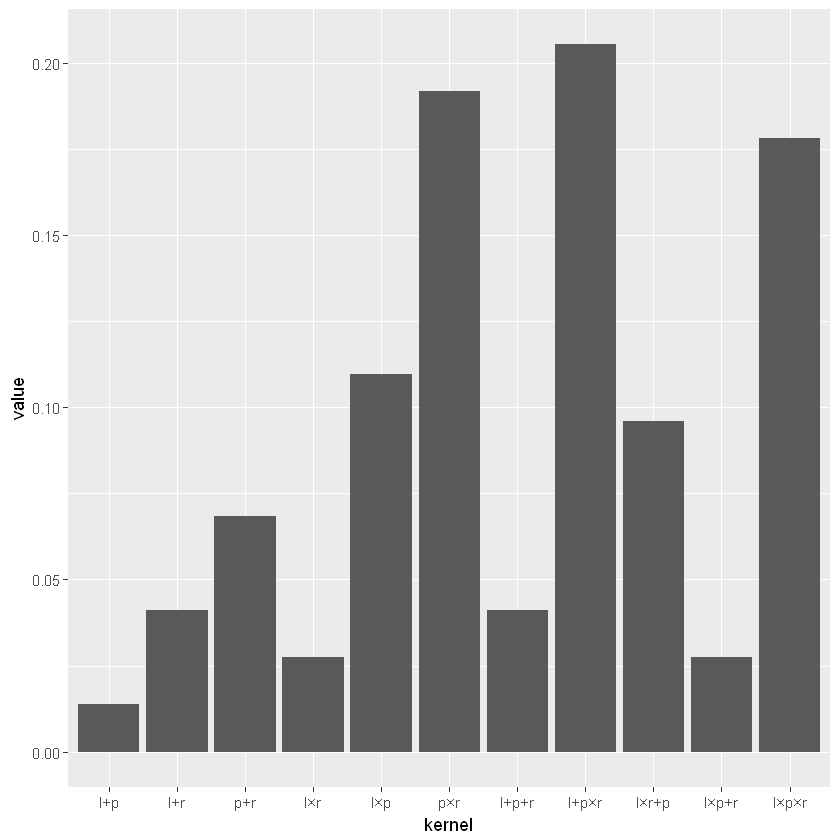

In [189]:
number_rows <- data_with_trend_ff %>% 
                    select(pid, kernel) %>% 
                    unique %>%
                    nrow

# Ordering the kernels
data_with_trend_ff_ordered <- data_with_trend_ff
data_with_trend_ff_ordered$kernel <- factor(data_with_trend_ff_ordered$kernel, levels = kernels_2)

# Producing the proportions
data_with_trend_ff_ordered %>% 
    select(pid, kernel) %>% 
    unique %>%
    group_by(kernel) %>%
    summarize(value = length(kernel) / number_rows) %>%

# Making the plot
    ggplot(aes(x=kernel, y=value)) + 
    geom_bar(stat='identity')

### Trend damping statistical tests

##### i) Proportion of trend damping along

In [150]:
damped_to_test <- merge(
        x = damped_proportion_2 %>% filter(type == 'Participants') %>% select(condition, day, damped_proportion),

        y = damped_proportion_2 %>% filter(type == 'Models') %>% select(condition, day, damped_proportion),

        by = c('condition', 'day'),
        suffixes = c('_participants', '_models')) %>%
        mutate(subtraction = damped_proportion_participants - damped_proportion_models) %>%
        filter(day <= 365 * 2)

c = 'Posterior-Positive'
print(c)
fit <- lm( damped_proportion_participants ~ damped_proportion_models, 
            data = damped_to_test %>% filter(condition == c))
summary(fit)

c = 'Posterior-Negative'
print(c)
fit <- lm( damped_proportion_participants ~ damped_proportion_models, 
            data = damped_to_test %>% filter(condition == c))
summary(fit)

[1] "Posterior-Positive"



Call:
lm(formula = damped_proportion_participants ~ damped_proportion_models, 
    data = damped_to_test %>% filter(condition == c))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.111649 -0.006386  0.007022  0.007022  0.084469 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)               -0.5238     0.1010  -5.185  1.7e-06 ***
damped_proportion_models   1.4905     0.1031  14.462  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.03208 on 77 degrees of freedom
Multiple R-squared:  0.7309,	Adjusted R-squared:  0.7274 
F-statistic: 209.2 on 1 and 77 DF,  p-value: < 2.2e-16


[1] "Posterior-Negative"



Call:
lm(formula = damped_proportion_participants ~ damped_proportion_models, 
    data = damped_to_test %>% filter(condition == c))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.04737 -0.03013  0.02701  0.02701  0.11225 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)               -0.4237     0.1744  -2.429   0.0175 *  
damped_proportion_models   1.3967     0.1760   7.935 1.35e-11 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.0339 on 77 degrees of freedom
Multiple R-squared:  0.4499,	Adjusted R-squared:  0.4427 
F-statistic: 62.97 on 1 and 77 DF,  p-value: 1.355e-11


###### ii) First damped point

In [138]:
first_point_damped <- merge(
    x = data_with_trend_ff %>% 
            group_by(pid, condition, scenario) %>%
            filter(damped_participant) %>%
            #filter(day > 365) %>% # <---- VERY IMPORTANT
            summarize(min_day = min(day)),
    
    y = data_with_trend_ff %>% 
            group_by(pid, condition, scenario) %>%
            filter(damped_model) %>%
            #filter(day > 365) %>% # <---- VERY IMPORTANT
            summarize(min_day = min(day)),
    
    by = c('pid', 'condition', 'scenario'),

    suffixes = c('_participants', '_models')) %>%

    mutate(subtraction = min_day_participants - min_day_models)# %>% filter(min_day_participants != 336)

fit_model_aux <- function(condition_name){
    print(condition_name)
    fit <- lm(min_day_participants ~ min_day_models, 
              data = first_point_damped %>% filter(condition == condition_name))
    summary(fit)
}

fit_model_aux("Posterior-Positive")
fit_model_aux("Posterior-Negative")

[1] "Posterior-Positive"



Call:
lm(formula = min_day_participants ~ min_day_models, data = first_point_damped %>% 
    filter(condition == condition_name))

Residuals:
   Min     1Q Median     3Q    Max 
-64.96 -19.86 -19.86 -19.86 310.14 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)  
(Intercept)    135.1419   131.3404   1.029   0.3104  
min_day_models   0.6569     0.3806   1.726   0.0929 .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 64.78 on 36 degrees of freedom
Multiple R-squared:  0.07644,	Adjusted R-squared:  0.05079 
F-statistic:  2.98 on 1 and 36 DF,  p-value: 0.09289


[1] "Posterior-Negative"



Call:
lm(formula = min_day_participants ~ min_day_models, data = first_point_damped %>% 
    filter(condition == condition_name))

Residuals:
    Min      1Q  Median      3Q     Max 
-24.952  -7.146  -7.146  -7.146 149.401 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -444.8822   110.4283  -4.029  0.00031 ***
min_day_models    2.3453     0.3247   7.223 2.78e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 30.66 on 33 degrees of freedom
Multiple R-squared:  0.6125,	Adjusted R-squared:  0.6008 
F-statistic: 52.17 on 1 and 33 DF,  p-value: 2.779e-08


##### iii) Damped proportion per participant

In [51]:
up_bound_day <- 365*2 + 30

damped_mean_per_pid <- data_with_trend_ff %>% 
                            group_by(pid, condition, scenario) %>%
                            filter(day < up_bound_day) %>%
                            summarize(damped_mean_participant = mean(damped_participant),
                                      damped_mean_model = mean(damped_model))

# Filter out those participants that were fully damped all along
damped_mean_per_pid_f <- damped_mean_per_pid %>% filter(damped_mean_participant < 1)

# Can the MODEL predict the PARTICIPANT?
fit_model_aux <- function(condition_name){
    print(condition_name)
    fit <- lm(damped_mean_participant ~ damped_mean_model,
              data = damped_mean_per_pid %>% filter(condition == condition_name))
    summary(fit)   
}

print(fit_model_aux(condition_name = 'Posterior-Positive'))
print(fit_model_aux(condition_name = 'Posterior-Negative'))

[1] "Posterior-Positive"

Call:
lm(formula = damped_mean_participant ~ damped_mean_model, data = damped_mean_per_pid %>% 
    filter(condition == condition_name))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.39823 -0.04075  0.06956  0.06956  0.13070 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)         0.6830     0.1267   5.389  4.9e-05 ***
damped_mean_model   0.2475     0.1347   1.837   0.0837 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1268 on 17 degrees of freedom
Multiple R-squared:  0.1657,	Adjusted R-squared:  0.1166 
F-statistic: 3.376 on 1 and 17 DF,  p-value: 0.08372

[1] "Posterior-Negative"

Call:
lm(formula = damped_mean_participant ~ damped_mean_model, data = damped_mean_per_pid %>% 
    filter(condition == condition_name))

Residuals:
       1        2        3        4        5        6 
 0.05327 -0.00444 -0.00444 -0.00444 -0.00444 -0.03552 

Coefficients:
    

In [53]:
# Should be zero because every curve and day combination should only have 1 datapoint
print('should be zero:')

data_with_trend %>% 
    group_by(cid, day) %>%
    filter(length(day) != 1) %>% nrow

data_with_trend %>% 
    group_by(cid, day, kernel) %>%
    filter(length(kernel) != 1) %>% nrow

[1] "should be zero:"


[1] 0

[1] 0

# Posterior analysis, proportion of match

In [82]:
error_posterior_incomplete <- results_pred %>% 
                                    mutate(true_lml = lml,
                                           lml = -error) # This is just for function reasons

error_posterior <- merge( x = error_posterior_incomplete,
                          y = lmls_posterior_ff %>% select(pid, condition, scenario) %>% unique,
                          by = c('pid', 'scenario'))

print('Should be TRUE:')
print(error_posterior %>% nrow == 7724)

[1] "Should be TRUE:"
[1] TRUE


In [83]:
# Remove the non-compositional kernels AND leave only the best-fitting kernel for each (pid, scenario)
best_fitting_per_pid_scenario <- function(lmls_ff) {
   lmls_ff %>%
    filter( kernel != 'l', kernel != 'p', kernel != 'r' ) %>%
    group_by( pid, condition, scenario ) %>%
    summarize( best_kernel = kernel[which.max(lml)],
               lml         =    lml[which.max(lml)])  
}

best_fit_and_merge <- function(prior_data, posterior_data){
    # Adding condition to the prior_data
    prior_data$condition <- 'Prior'
    
    best_in_prior <- best_fitting_per_pid_scenario(prior_data)
    best_in_posterior <- best_fitting_per_pid_scenario(posterior_data)

    # Merging the best fitting compositions
    aux_best_fitting_kernels <- merge(
                                x = best_in_prior,
                                y = best_in_posterior,
                                by = c('pid', 'scenario'),
                                suffixes = c('_prior', '_posterior')
    )
    
    return(aux_best_fitting_kernels)
}

best_fitting_kernels <- best_fit_and_merge(lmls_prior_ff, error_posterior)

In [84]:
# Now we have to check and calculate the proportions of match
match_per_condition <- best_fitting_kernels %>%
    mutate(match = (best_kernel_prior == best_kernel_posterior)) %>%
    group_by(condition_posterior) %>%
    summarize(match_proportion = bp2(match, alpha=0.05, round_n=3)[1], 
              lo_ci            = bp2(match, alpha=0.05, round_n=3)[2], 
              hi_ci            = bp2(match, alpha=0.05, round_n=3)[3])

match_per_scenario <- best_fitting_kernels %>%
    mutate(match = (best_kernel_prior == best_kernel_posterior)) %>%
    group_by(scenario) %>%
    summarize(match_proportion = bp2(match, alpha=0.05, round_n=3)[1], 
              lo_ci            = bp2(match, alpha=0.05, round_n=3)[2], 
              hi_ci            = bp2(match, alpha=0.05, round_n=3)[3])

Observing the results:

In [85]:
print(paste('Reference:', round(1/11, 3)))

match_per_condition
match_per_scenario

[1] "Reference: 0.091"


condition_posterior,match_proportion,lo_ci,hi_ci
Posterior-Negative,0.139,0.097,0.185
Posterior-Positive,0.131,0.088,0.172
Posterior-Stable,0.126,0.084,0.168


scenario,match_proportion,lo_ci,hi_ci
FB Friends,0.076,0.034,0.126
Gym members,0.169,0.101,0.235
Rain,0.185,0.118,0.252
Salary,0.126,0.067,0.185
Sales,0.093,0.042,0.143
Temperature,0.143,0.084,0.210


#### Actual tests

##### Per condition (not used)

In [86]:
x_n_per_condition <- best_fitting_kernels %>%
                        mutate(match = (best_kernel_prior == best_kernel_posterior)) %>%
                        group_by(condition_posterior) %>%
                        summarize(x = sum(match), n = length(match))

x_n_per_condition

condition_posterior,x,n
Posterior-Negative,33,238
Posterior-Positive,31,238
Posterior-Stable,30,238


In [87]:
binom_test_special <- function (dataset, condition_name) {
    x <- (dataset %>% filter(condition_posterior == condition_name))$x
    n <- (dataset %>% filter(condition_posterior == condition_name))$n
    
    print(condition_name)
    binom.test(x, n, p=1/11, alternative="two.sided", conf.level=0.95)
}

In [88]:
binom_test_special_2 <- function (dataset, condition_name) {
    y <- (best_fitting_kernels %>%
                filter(condition_posterior == condition_name) %>%
                mutate(match = (best_kernel_prior == best_kernel_posterior)))$match * 1
    
    print(condition_name)
    #binom.test(x, n, p=1/11, alternative="two.sided", conf.level=0.95)
    t.test(y, mu = 1/11) # Ho: mu=3 
}
binom_test_special_2(x_n_per_condition, "Posterior-Negative")

[1] "Posterior-Negative"



	One Sample t-test

data:  y
t = 2.127, df = 237, p-value = 0.03446
alternative hypothesis: true mean is not equal to 0.09090909
95 percent confidence interval:
 0.09443184 0.18287908
sample estimates:
mean of x 
0.1386555 


In [89]:
binom_test_special(x_n_per_condition, "Posterior-Negative")
binom_test_special(x_n_per_condition, "Posterior-Stable")
binom_test_special(x_n_per_condition, "Posterior-Positive")

[1] "Posterior-Negative"



	Exact binomial test

data:  x and n
number of successes = 33, number of trials = 238, p-value = 0.01707
alternative hypothesis: true probability of success is not equal to 0.09090909
95 percent confidence interval:
 0.09740411 0.18917909
sample estimates:
probability of success 
             0.1386555 


[1] "Posterior-Stable"



	Exact binomial test

data:  x and n
number of successes = 30, number of trials = 238, p-value = 0.06999
alternative hypothesis: true probability of success is not equal to 0.09090909
95 percent confidence interval:
 0.08668616 0.17503235
sample estimates:
probability of success 
             0.1260504 


[1] "Posterior-Positive"



	Exact binomial test

data:  x and n
number of successes = 31, number of trials = 238, p-value = 0.04165
alternative hypothesis: true probability of success is not equal to 0.09090909
95 percent confidence interval:
 0.09024432 0.17976189
sample estimates:
probability of success 
             0.1302521 


##### By scenario

In [90]:
x_n_per_scenario <- best_fitting_kernels %>%
                        mutate(match = (best_kernel_prior == best_kernel_posterior)) %>%
                        group_by(scenario) %>%
                        summarize(x = sum(match), n = length(match))

x_n_per_scenario

scenario,x,n
FB Friends,9,119
Gym members,20,119
Rain,22,119
Salary,15,119
Sales,11,119
Temperature,17,119


In [91]:
binom_test_special_scenario <- function (dataset, scenario_name) {
    x <- (dataset %>% filter(scenario == scenario_name))$x
    n <- (dataset %>% filter(scenario == scenario_name))$n
    
    print(scenario_name)
    binom.test(x, n, p=1/11, alternative="two.sided", conf.level=0.95)
}

for(scn in readable_scenarios){
    print(binom_test_special_scenario(x_n_per_scenario, scn))
}

[1] "Temperature"

	Exact binomial test

data:  x and n
number of successes = 17, number of trials = 119, p-value = 0.0551
alternative hypothesis: true probability of success is not equal to 0.09090909
95 percent confidence interval:
 0.0854768 0.2188484
sample estimates:
probability of success 
             0.1428571 

[1] "Rain"

	Exact binomial test

data:  x and n
number of successes = 22, number of trials = 119, p-value = 0.001187
alternative hypothesis: true probability of success is not equal to 0.09090909
95 percent confidence interval:
 0.1196370 0.2664134
sample estimates:
probability of success 
             0.1848739 

[1] "Sales"

	Exact binomial test

data:  x and n
number of successes = 11, number of trials = 119, p-value = 0.8738
alternative hypothesis: true probability of success is not equal to 0.09090909
95 percent confidence interval:
 0.04705217 0.15937705
sample estimates:
probability of success 
            0.09243697 

[1] "Gym members"

	Exact binomial test

da

# Posterior analysis, participants' data, proportion of match

In [379]:
# Prior data
lmls_prior_ff$condition <- 'Prior'

# Posterior data (participants (i.e., no evidence))
lmls_posterior_participants_ff <- get_filtered_data( "output/minus-mean-treatment/results_posterior_participants_lmls.csv",
                                                     "data/for_composititional_analysis_posterior.csv" )

# Readable kernel composition
lmls_posterior_participants_ff$kernel <- readable_kernel(lmls_posterior_participants_ff$kernel)

Parsed with column specification:
cols(
  id = col_integer(),
  kernel = col_character(),
  lml = col_double(),
  white_added = col_character(),
  second_exception = col_character()
)
Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  X1 = col_integer(),
  id = col_integer(),
  pid = col_character(),
  scenario = col_character(),
  x = col_integer(),
  y = col_double(),
  condition = col_character()
)


In [385]:
# Percentage of removed data points:
((1 -
lmls_posterior_participants_ff %>%
    filter(kernel != 'l', kernel != 'p', kernel != 'r') %>%
    nrow / 
read_csv('output/minus-mean-treatment/results_posterior_participants_lmls.csv') %>%
    filter(kernel != 'l', kernel != 'p', kernel != 'r') %>%
    nrow) * 100) %>%
round(2)


Parsed with column specification:
cols(
  id = col_integer(),
  kernel = col_character(),
  lml = col_double(),
  white_added = col_character(),
  second_exception = col_character()
)


[1] 1.43

In [93]:
best_fitting_kernels <- best_fit_and_merge(lmls_prior_ff, 
                                           lmls_posterior_participants_ff)

# Now we have to check and calculate the proportions of match
match_per_scenario <- best_fitting_kernels %>%
    mutate(match = (best_kernel_prior == best_kernel_posterior)) %>%
    group_by(scenario) %>%
    summarize(match_proportion = bp2(match, alpha=0.05, round_n=3)[1], 
              lo_ci            = bp2(match, alpha=0.05, round_n=3)[2], 
              hi_ci            = bp2(match, alpha=0.05, round_n=3)[3])

match_per_scenario

scenario,match_proportion,lo_ci,hi_ci
FB Friends,0.312,0.227,0.395
Gym members,0.352,0.269,0.437
Rain,0.529,0.437,0.622
Salary,0.336,0.252,0.420
Sales,0.143,0.084,0.210
Temperature,0.361,0.277,0.454


##### Statistical tests per scenario:

In [122]:
x_n_per_scenario <- best_fitting_kernels %>%
                        mutate(match = (best_kernel_prior == best_kernel_posterior)) %>%
                        group_by(scenario) %>%
                        summarize(x = sum(match), n = length(match))

x_n_per_scenario

for(scn in readable_scenarios){
    #print(binom_test_special_scenario(x_n_per_scenario, scn))
}

# Readable:
to_report = ''

for(scn in readable_scenarios){
    
    test_results_per_scenario <- binom_test_special_scenario(x_n_per_scenario, scn)
    
    proportion <- test_results_per_scenario[[5]][[1]] %>% round(2)
    
    df <- test_results_per_scenario[[2]]
    p_val <- ifelse(test_results_per_scenario[[3]] < 0.001, 
                "<0.001", 
                test_results_per_scenario[[3]])
    
    p_val <- ifelse(p_val > 0.05, 
                ">0.05", 
                p_val)
    
    t <- test_results_per_scenario[[1]] %>% round(2)
    
    #t_string <- paste0("$r=", proportion, "$ ($t(", df, ")=", t, "$, $p", p_val, "$)")
    t_string <- paste0("$\\hat{p}=", proportion, "$ ($x=", t, ", n=", df, ", p", p_val, "$)")
    
    to_return_scenario <- paste0(t_string, " for the ", scn, " data, ")
    
    to_report <- paste0(to_report, to_return_scenario)
    
    to_report = gsub("FB Friends data, ","Facebook friends data.", to_report)
}

print(to_report)

scenario,x,n
FB Friends,37,119
Gym members,42,119
Rain,63,119
Salary,40,119
Sales,17,119
Temperature,43,119


[1] "Temperature"
[1] "Rain"
[1] "Sales"
[1] "Gym members"
[1] "Salary"
[1] "FB Friends"
[1] "$\\hat{p}=0.36$ ($x=43, n=119, p<0.001$) for the Temperature data, $\\hat{p}=0.53$ ($x=63, n=119, p<0.001$) for the Rain data, $\\hat{p}=0.14$ ($x=17, n=119, p>0.05$) for the Sales data, $\\hat{p}=0.35$ ($x=42, n=119, p<0.001$) for the Gym members data, $\\hat{p}=0.34$ ($x=40, n=119, p<0.001$) for the Salary data, $\\hat{p}=0.31$ ($x=37, n=119, p<0.001$) for the Facebook friends data."
